In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import statistics

In [2]:
Trajectory_path = r"Trajectory_text_files/*Molecule *.csv"
DataSet_name = "210914_ExNo_68_FM4-64_60x_Pos2_"
SavePath = r"Transposed tracks\Analyzed//" 
Save_figures = 'n' #'Y' will save it

dt = 50
enough = 0
too_few= 0



In [4]:
#%% Listst to be filled
All_Speed = [] #euclidean p2p dist/time
All_Vel = [] # Velocity from euclidean p2p dist/time
All_Vel_Along_Spline = [] #from 1D displacement along drawn spline, MATLAB column 9
All_Vel_Transposed= [] #euclidean speed from first point till point i, MATLAB column 8
Track_length_in_Points = []
Stepsizes = []
Ort_positions = [] # position along the drawn spline, MATLAB column 7
Ort_displacements_p2pS = [] #point to point displacement
Total_Ort_displS = [] # Total ort displ
Displ_along_spline_p2pS = [] #1D displacement along drawn spline
Transposed_euclidean_dist_p2pS = [] # 

DisplS_along_spline_Cum = []

Total_Ort_positionS = []
Total_displacementS_along = []

Total_Ort_positionS_RolAVG10 = []
Tortuosities = []

#%%Analysis loop
for filename in glob.glob(Trajectory_path):
    df = pd.read_csv(filename, sep="\t")#, skiprows=1)
    
    x_position = df['x_position[nm]'].to_numpy() # put untransposed coordinates in array
    y_position = df['y_position[nm]'].to_numpy()
    diff_x = x_position[:-1] - x_position[1:] # calculate difference with previous row
    diff_y = y_position[:-1] - y_position[1:]
    df['x_displacement[nm]'] = np.insert(diff_x,0,0)        
    df['y_displacement[nm]'] = np.insert(diff_y,0,0)
    
    #Calculate euclidean distance and Speed (from untransposed coordinates)
    dist =  np.sqrt(diff_x **2 +diff_y**2)
    distMinus1st = np.insert(dist,0,np.nan)  
    df['Euclidean_p2p_distance[nm]'] = distMinus1st
    Stepsizes.append(dist)     
    Speed = dist/dt
    All_Speed.append(Speed) #appends the result of Speed calculations numpy array to the end of the All_Speed numpy array for every loop
    
    # Calculate signed Velocity from Speed (from untransposed coordinates)
    df['Speed[nm/s]'] = np.insert(Speed,0,np.nan)
    df['Velocity[nm/s]'] = df['Speed[nm/s]']*(2*(df['y_displacement[nm]'] >0)-1)
    All_Vel.append(df['Velocity[nm/s]'])
 
    
    #Convert cumulative distance along spline to p2p dustance along the spline
    Displ_along_spline_Cum = df['Cumulative_distance_along_spline_1D'].to_numpy()
    Displ_along_spline_p2p = Displ_along_spline_Cum[:-1] - Displ_along_spline_Cum[1:]
    Displ_along_spline_p2pS.append(Displ_along_spline_p2p)
    
    df['Displ_along_spline_p2p[nm]'] = np.insert(Displ_along_spline_p2p,0,np.nan)
    
    DisplS_along_spline_Cum.append(Displ_along_spline_Cum)

    #THIS DOES NOT CALCULATE WHAT i WANT IT TO, CHECK!!!
    Transposed_euclidean_dist_Cum = df['Cumulative_Euclidean_distance_2D'].to_numpy()
    Transposed_euclidean_dist_p2p = Transposed_euclidean_dist_Cum[:-1] - Transposed_euclidean_dist_Cum[1:]
    Transposed_euclidean_dist_p2pS.append(Transposed_euclidean_dist_p2p)
    
    df['Transposed_euclidean_dist_p2p[nm]'] = np.insert(Transposed_euclidean_dist_p2p,0,np.nan)
    
    
    #Orthogonal position from drawn spline  
    Ort_position = df['Orthogonal_distance_to_spline']
    Ort_positions.append(Ort_position)
    
    Ort_displacements_p2p =  Ort_position.shift(-1) - Ort_position
    Ort_displacements_p2pS.append(Ort_displacements_p2p)
    
    Total_Ort_displ = max(Ort_position) - min(Ort_position)
    Total_Ort_displS.append(Total_Ort_displ)
    
    #Get all the Velocities values calculated in the MATLAB column 5 script and add them to one list to make a histogram from     
    Vel_Transposed = df['P2P_Velocities_Cumulative_Euclidean_distance'].to_numpy()
    All_Vel_Transposed.append(Vel_Transposed/1000)  
    
    Vel_Along_Spline = df['P2P_Velocities_Distance_along_spline'].to_numpy()
    All_Vel_Along_Spline.append(Vel_Along_Spline/1000)
  
       
    #Calculate number of timepoints per trajectory and add to list of all trajectories
    Len = len(x_position)
    Track_length_in_Points.append(Len)
   
    
    ##Calculate Tortuosity
    # total euclidian displacement for one trajectory
    DisplTot_X = x_position[len(x_position)-1] - x_position[0]
    DisplTot_Y = y_position[len(y_position)-1] - y_position[0]
    DisplTot =  np.sqrt(DisplTot_X **2 + DisplTot_Y**2)
    Tortuosity = dist.sum()/DisplTot
    Tortuosities.append(Tortuosity)
    
    #Calculate max x and y displacement
    Total_Ort_position = max(Ort_position)-min(Ort_position)
    Total_Ort_positionS.append(Total_Ort_position)
    
    Total_displacement_along_spline= max(Displ_along_spline_p2p)-min(Displ_along_spline_p2p)
    Total_displacementS_along.append(Total_displacement_along_spline)
    
    #Caculate ort displacements from transposed stuff for a certain range
    # Ort_position_30_points = max(Ort_position[0:9])-min(Ort_position[0:9])
    # Ort_positions_30_points.append(Ort_position_30_points)
     
         
    # add arrays to existing dataframe 
    df["Speed_rolling_average[nm/s]"] = df['Speed[nm/s]'].rolling(window=10).mean()
    
    #check what files have Veklocities over 100 um/s in then
    if df['Speed[nm/s]'].gt(100).any():
        print("These files have a Speed value of over 100 um/s")
        print(filename)
         
    # safe new dataframe with the columns 'header' in specified location
#     header = ["frame", "time[s]","x_position[nm]","y_position[nm]","Cumulative_Euclidean_distance_2D",
#                                                 "Cumulative_distance_along_spline_1D","Orthogonal_distance_to_spline",
#                                                 "P2P_Velocities_Cumulative_Euclidean_distance","P2P_Velocities_Distance_along_spline",
#                                                 'Euclidean_p2p_distance[nm]', 'Speed[nm/s]', 'Velocity[nm/s]', 'Displ_along_spline_p2p[nm]',
#                                                 'Transposed_euclidean_dist_p2p[nm]', ]
#     names = DataSet_name + "Velo Molecule " + filename.split("Molecule ")[1][:-4] + ".txt"
#     df.to_csv(SavePath + names, sep='\t', encoding='utf-8', index=False, columns = header)
    
    #plot figure
    # fig1 = plt.figure(1, figsize=(10,10))
    # plot(df.index, SpeedMinus1st, marker='o', linewidth=0.5, markersize=3, markerfacecolor='none', markeredgewidth=1) #label="Mol "+ filename.split("Molecule ")[1][:-4])
    # # plt.legend(framealpha=0, loc='best', bbox_to_anchor=(0.8, 0.53, 0.5, 0.5)) #labelcolor=COLOR,
    # plt.xlabel("frame #")
    # plt.ylabel("velocity (\u03BCm/s)")  
    
    # fig2 = plt.figure(2, figsize=(10,10))
    # plot(df['time[s]'], df["RolAvg_Orth(x)Displ [nm]"],linewidth=0.5, markersize=3, markerfacecolor='none', markeredgewidth=1) #label="Mol "+ filename.split("Molecule ")[1][:-4])
    # plt.xlabel("time [s]")
    # plt.ylabel("Rolling average Orthogonal displacement [nm/s]") 
       
    
     
    #If I want to check how many coordinates there are in a file with this filename
    # print("# of x_values in Mol", filename.split("Molecule ",1)[1][:-4], "=", len(x_values))
     
      
    
    
    
    # print("Number of Trajectories with > 10 datapoints = ", enough)        
    # print("Number of Trajectories with < 10 datapoints = ", too_few)   


#%% Calculate statistics and write to new dataframe,transpose it, and save it

#Concatenate arrays so it are lists with all the values behind each other

All_Speed =  np.concatenate(All_Speed) #euclidean p2p dist/time
All_Vel =  np.concatenate(All_Vel) # Velocity from euclidean p2p dist/time
All_Vel_Along_Spline =  np.concatenate(All_Vel_Along_Spline) #from 1D displacement along drawn spline, MATLAB column 9
All_Vel_Transposed=  np.concatenate(All_Vel_Transposed) #euclidean speed from first point till point i, MATLAB column 8
Stepsizes =  np.concatenate(Stepsizes)
DisplS_along_spline_Cum = np.concatenate(DisplS_along_spline_Cum)

Ort_positions =  np.concatenate(Ort_positions) # position along the drawn spline, MATLAB column 7
Ort_displacements_p2pS = np.concatenate(Ort_displacements_p2pS)
Displ_along_spline_p2pS =  np.concatenate(Displ_along_spline_p2pS) #1D displacement along drawn spline
Transposed_euclidean_dist_p2pS =  np.concatenate(Transposed_euclidean_dist_p2pS) # 

These files have a Speed value of over 100 um/s
Trajectory_text_files\210914_ExNo_68_FM4-64_60x_Pos2_Molecule 1.csv


In [5]:
df

,frame,time[s],x_position[nm],y_position[nm],Cumulative_Euclidean_distance_2D,Cumulative_distance_along_spline_1D,Orthogonal_distance_to_spline,P2P_Velocities_Cumulative_Euclidean_distance,P2P_Velocities_Distance_along_spline,x_displacement[nm],y_displacement[nm],Euclidean_p2p_distance[nm],Speed[nm/s],Velocity[nm/s],Displ_along_spline_p2p[nm],Transposed_euclidean_dist_p2p[nm],Speed_rolling_average[nm/s]
0,959.0,47.900002,2666.488281,47513.089844,0.000000,1602.836764,94.313385,2725.197731,2849.013900,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,960.0,47.950001,2679.716064,47359.757812,153.901550,1763.092944,114.587608,2363.780128,2706.406546,-13.227783,153.332031,153.901547,3.078031,3.078031,-160.256180,-153.901550,NaN
2,961.0,48.000000,2699.337646,47260.343750,254.871872,1869.926148,117.676956,2382.360553,2533.292667,-19.621582,99.414062,101.331941,2.026639,2.026639,-106.833204,-100.970322,NaN
3,962.0,48.049999,2758.063232,47149.917969,374.539429,2030.169073,89.444275,2616.457829,2594.161379,-58.725586,110.425781,125.070171,2.501403,2.501403,-160.242926,-119.667557,NaN
4,963.0,48.099998,2744.643555,47030.464844,488.912201,2136.992809,127.648636,2607.727393,2610.961642,13.419678,119.453125,120.204562,2.404091,2.404091,-106.823736,-114.372772,NaN
5,964.0,48.150002,2789.124268,46934.531250,591.413269,2243.812405,107.510872,2452.760544,2492.346443,-44.480713,95.933594,105.743975,2.114879,2.114879,-106.819596,-102.501068,NaN
6,965.0,48.200001,2810.795410,46775.789062,751.290222,2404.033594,122.911537,2514.278986,2492.239238,-21.671143,158.742188,160.214608,3.204292,3.204292,-160.221189,-159.876953,NaN
7,966.0,48.250000,2828.035400,46633.183594,894.613037,2510.841956,137.126953,2588.305825,2492.069599,-17.239990,142.605469,143.643785,2.872876,2.872876,-106.808362,-143.322815,NaN
8,967.0,48.299999,2855.282959,46500.644531,1029.897461,2671.045348,141.396545,2765.096785,2729.207434,-27.247559,132.539062,135.310874,2.706217,2.706217,-160.203392,-135.284424,NaN
9,968.0,48.349998,2894.193359,46361.843750,1173.548950,2777.841215,137.062714,2897.571763,2847.467844,-38.910400,138.800781,144.151573,2.883031,2.883031,-106.795866,-143.651489,NaN


(-0.5, 18.0)

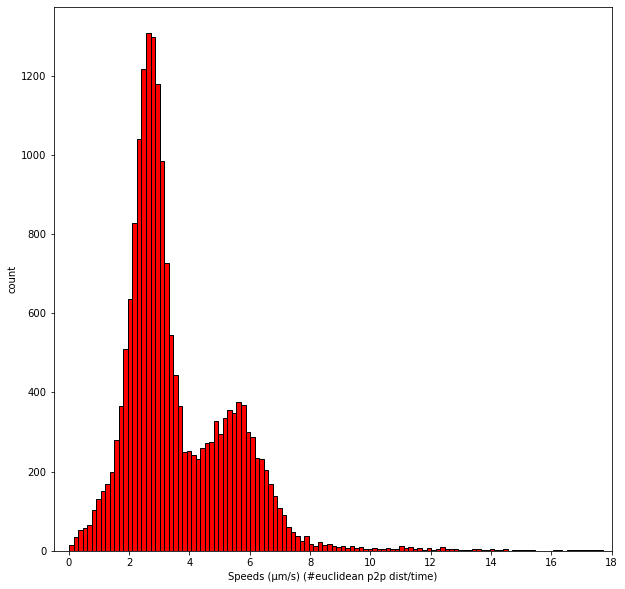

In [6]:
fig2 =plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(1, 1, 1)
ax2.hist(All_Speed, bins=np.arange(min(All_Speed), max(All_Speed) + 2, 0.15),color='r', edgecolor='black')
ax2.set_xlabel("Speeds (\u03BCm/s) (#euclidean p2p dist/time)")
ax2.set_ylabel("count")
ax2.locator_params(axis='x', nbins=18)
ax2.set_xlim([-0.5, 18])

(-750.0, 500.0)

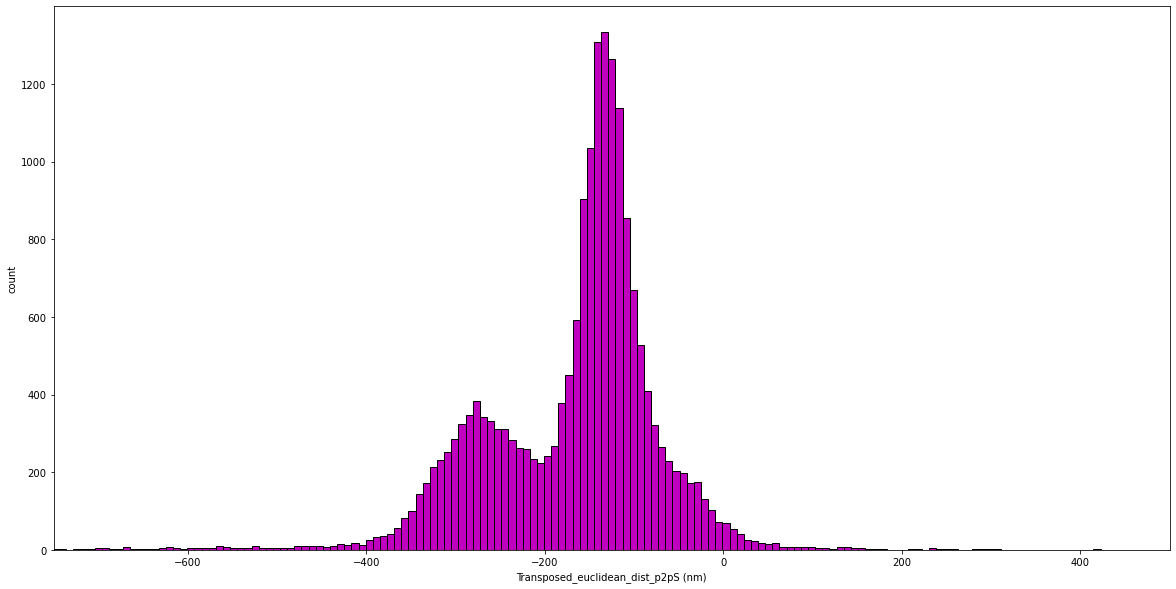

In [7]:
fig71 =plt.figure(figsize=(20,10))
ax71 = fig71.add_subplot(1, 1, 1)
ax71.hist(Transposed_euclidean_dist_p2pS, bins=1000,color='m', edgecolor='black') 
ax71.set_xlabel("Transposed_euclidean_dist_p2pS (nm)")
ax71.set_ylabel("count")
ax71.set_xlim([-750, 500])
